# Adversarial example using FGSM

In [2]:
import tensorflow as tf

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [6]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 97s 7us/step


In [7]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)

In [8]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 
                                     'https://storage.googleapis.com/download.tensorflow.org/example_images.YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)
image_probs = pretrained_model.predict(image)

[[('n02099712', 'Labrador_retriever', 0.41818467)]]


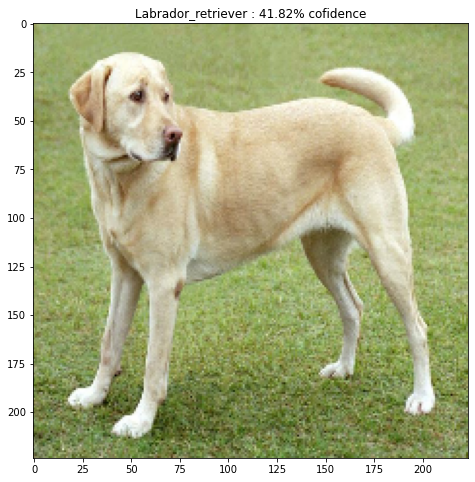

In [19]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)
output = get_imagenet_label(image_probs)
print(output)
plt.title('{} : {:.2f}% cofidence'.format(output[0][0][1], output[0][0][2] * 100))
plt.show()

In [20]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

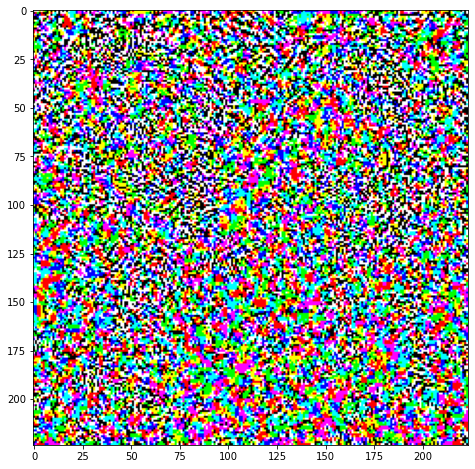

In [25]:
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5)

In [29]:
def display_images(image, description):
    output = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, output[0][0][1], output[0][0][2]))
    plt.show()

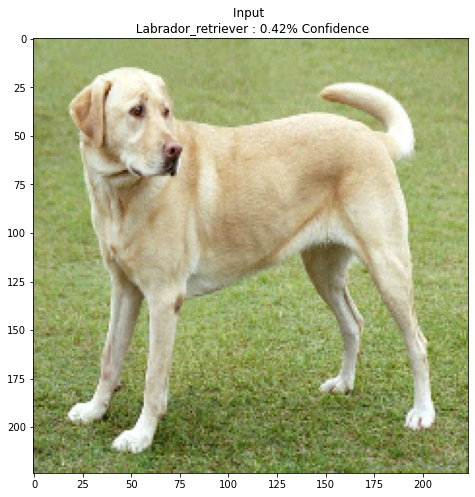

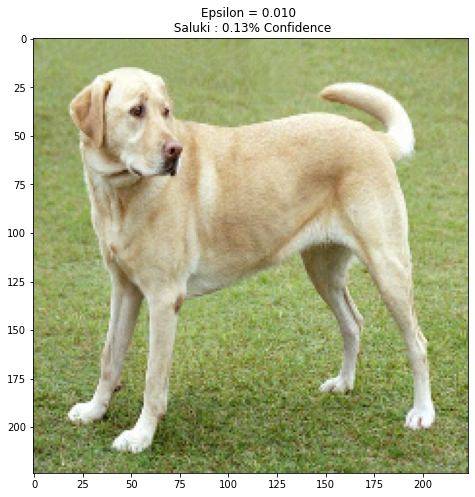

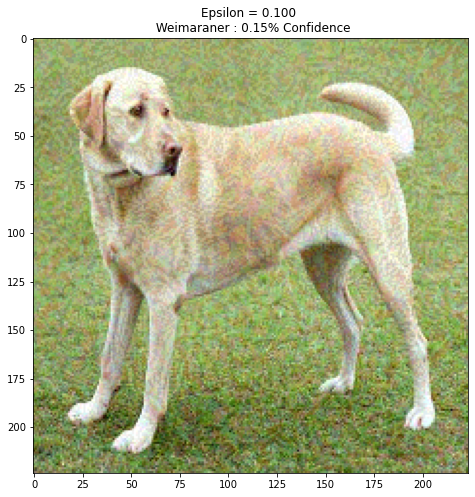

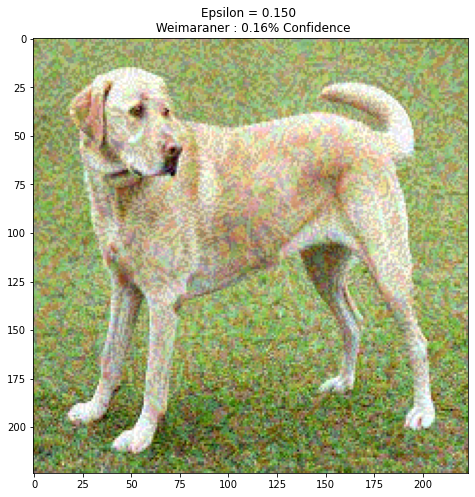

In [30]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else "Input") for eps in epsilons]
for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])

# Intro to Autoencoders

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [32]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [33]:
latent_dim = 64
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.Flatten(), 
                                           layers.Dense(latent_dim, activation='relu')])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
autoencoder = Autoencoder(latent_dim)

In [34]:
autoencoder.compile(optimizer="adam", loss=losses.MeanSquaredError())

In [35]:
autoencoder.fit(x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.0235 - val_loss: 0.0130
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0

In [36]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

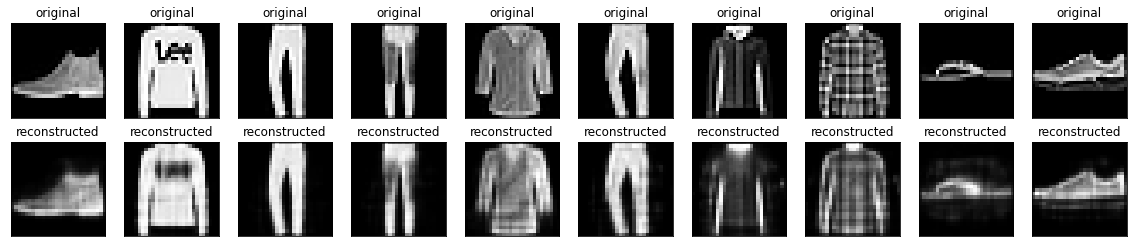

In [38]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [39]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [40]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(x_train.shape)

(60000, 28, 28, 1)


In [41]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

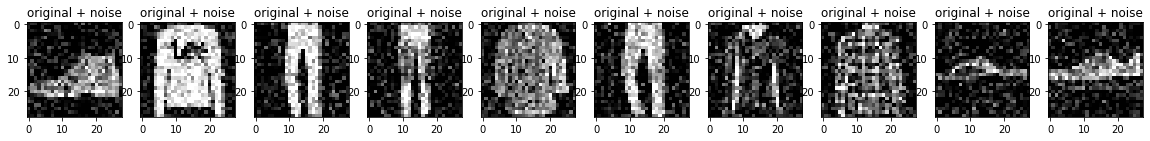

In [42]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [43]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding="same", strides=2),
            layers.Conv2D(8, (3, 3), activation="relu", padding="same", strides=2)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation="relu", padding="same"),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding="same")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
autoencoder = Denoise()

In [45]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [46]:
autoencoder.fit(x_train_noisy, x_train, epochs=10, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 91s 48ms/step - loss: 0.0172 - val_loss: 0.0106
Epoch 2/10
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0095 - val_loss: 0.0088
Epoch 3/10
1875/1875 [==============================] - 102s 54ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 4/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 5/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 7/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 8/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 9/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/10
1875/1875 [==============================] - 61s 3

In [47]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [48]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [49]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

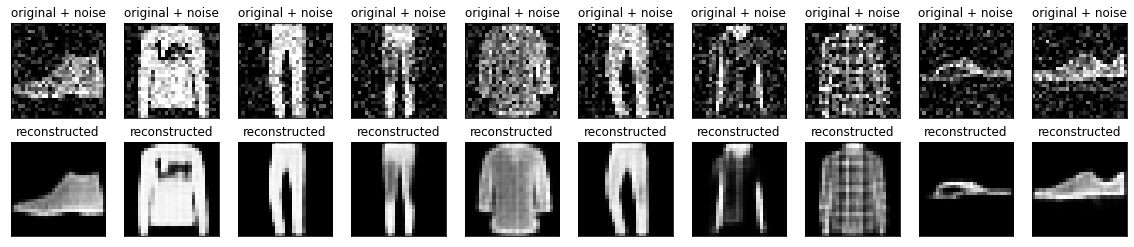

In [51]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    bx = plt.subplot(2, n, i + 1 + n)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [52]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.257740  0.228077  0.123431  0.925286  0.193137  1.0  
1  0.555784  0.476333  0.773820  1.119621 -1.436250  1.0  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797  1.0  
3  0.952074  0.990133  1.086798  1.403011 -0.383564  1.0  
4  1.277392  0.960304  0.971020  1.614392  1.421456  1.0  

[5 rows x 141 columns]

In [53]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

In [54]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [56]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

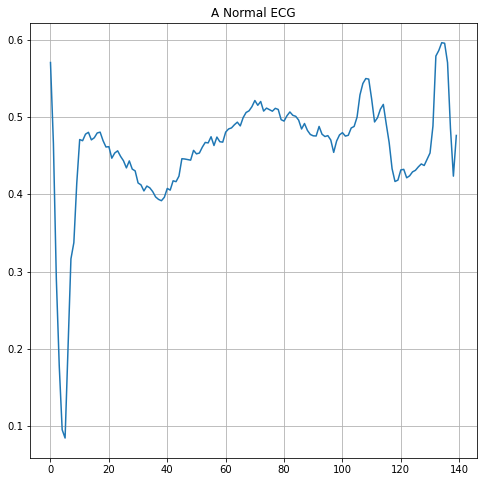

In [57]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

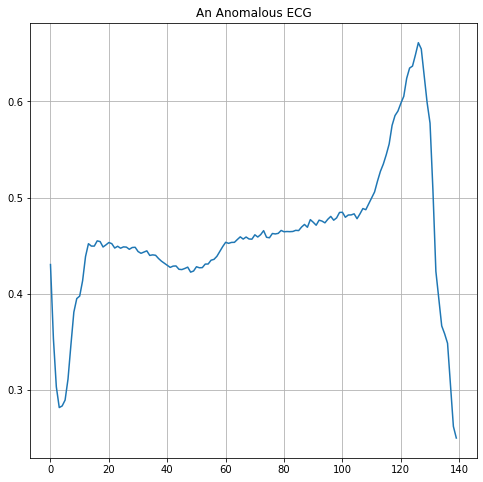

In [58]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [62]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
autoencoder = AnomalyDetector()

In [63]:
autoencoder.compile(optimizer="adam", loss="mae")

In [64]:
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=20, batch_size=512, 
                          validation_data = (test_data, test_data), shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 30ms/step - loss: 0.0579 - val_loss: 0.0525
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0533 - val_loss: 0.0502
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0488 - val_loss: 0.0495
Epoch 4/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0450 - val_loss: 0.0462
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0412 - val_loss: 0.0441
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0381 - val_loss: 0.0430
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0354 - val_loss: 0.0411
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0331 - val_loss: 0.0402
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0312 - val_loss: 0.0390
Epoch 10/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0294 - val_loss: 0.0381
Epoch 11/20
5/5 [==================

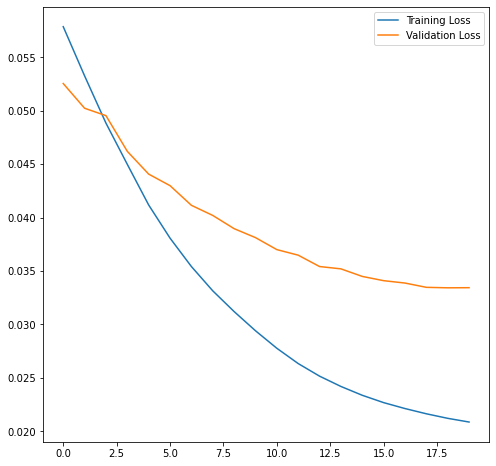

In [65]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

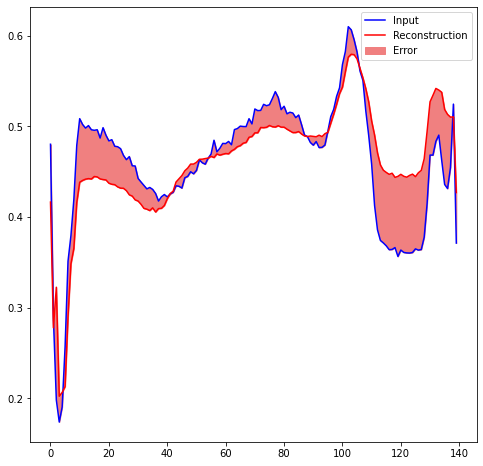

In [66]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color="lightcoral")
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

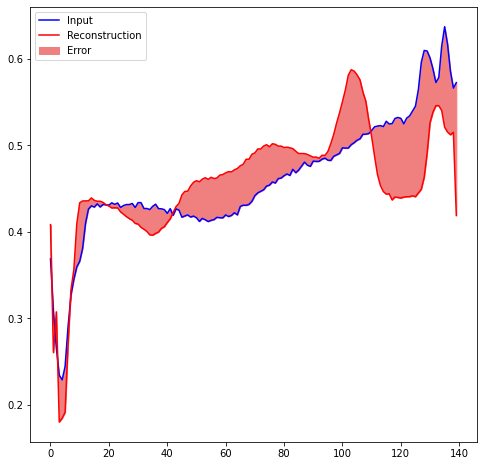

In [67]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

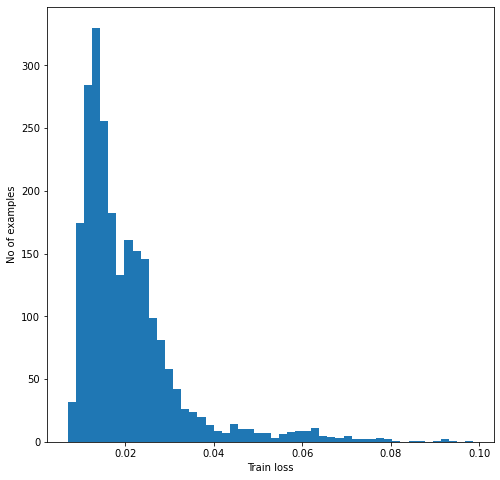

In [69]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [70]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:", threshold)

Threshold: 0.032629937


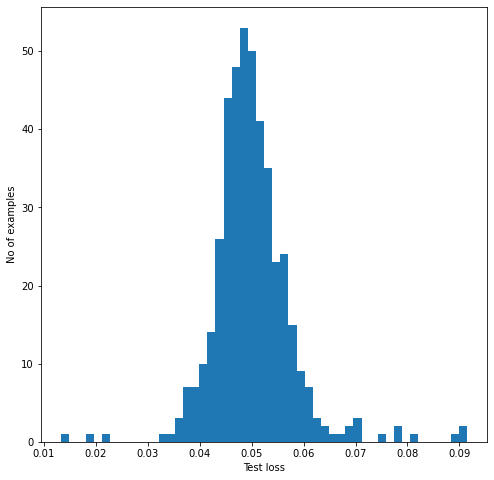

In [71]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [74]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [75]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9941176470588236
Recall = 0.9053571428571429


# Convolutional Variational Autoencoder

In [1]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [5]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [6]:
train_size = 60000
batch_size = 32
test_size = 10000

In [8]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

In [23]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same")
        ])
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    def parameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [30]:
optimizer = tf.keras.optimizers.Adam(1e-4)
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.parameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [31]:
epochs = 10
latent_dim = 2
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [32]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.parameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [33]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -3901.05029296875, time elapse for current epoch: 52.179526567459106


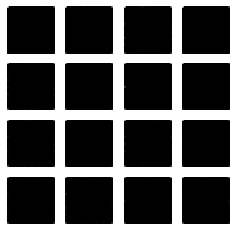

In [34]:
generate_and_save_images(model, 0, test_sample)
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()
    
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=True)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

In [36]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

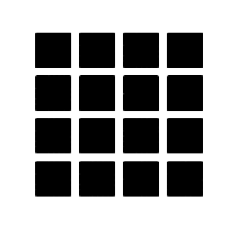

In [37]:
plt.imshow(display_image(epoch))
plt.axis('off')

# Integrated gradients

In [38]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [39]:
model = tf.keras.Sequential([
    hub.KerasLayer(name='inception_v1', handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4', 
                   trainable=False)
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [40]:
def load_imagenet_labels(file_path):
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

In [41]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [42]:
def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

In [48]:
img_url = {
    'Fireboat':'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Pandas': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg'
}
img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

819200/802859 [==============================] - 2s 2us/step


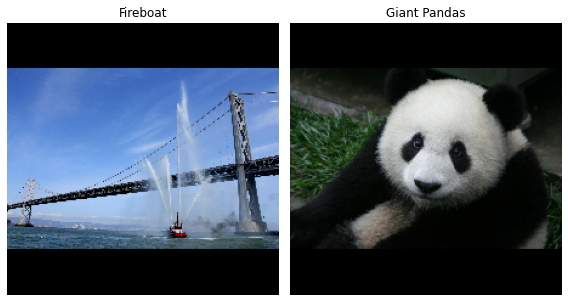

In [49]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(1, 2, n + 1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

In [50]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    predictions = model(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

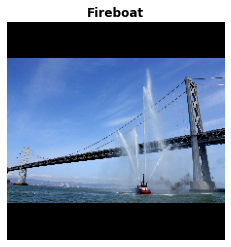

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


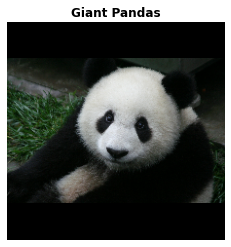

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [51]:
for (name, img_tensor) in img_name_tensors.items():
    plt.imshow(img_tensor)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()
    pred_label, pred_prob = top_k_predictions(img_tensor)
    for label, prob in zip(pred_label, pred_prob):
        print(f'{label}: {prob:0.1%}')

In [52]:
def f(x):
    return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
    return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

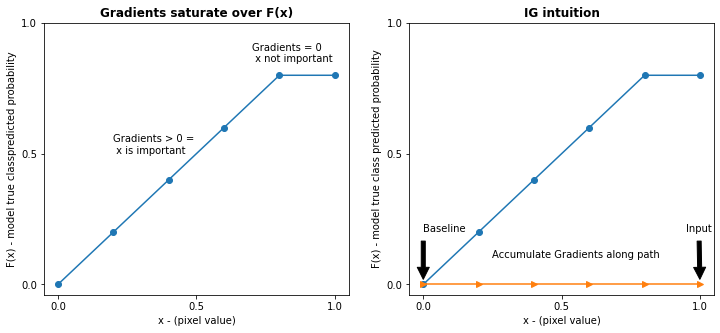

In [54]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true classpredicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate Gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy = (0.0, 0.0), xytext=(0.0, 0.2), arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2), arrowprops=dict(facecolor="black", shrink=0.1))
plt.show()

In [55]:
baseline = tf.zeros(shape=(224, 224, 3))

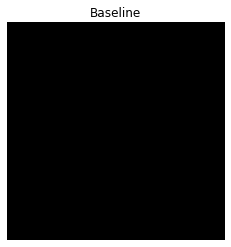

In [56]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis("off")
plt.show()

In [57]:
m_steps = 50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps + 1)

In [58]:
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images

In [59]:
interpolated_images = interpolate_images(baseline=baseline, image=img_name_tensors['Fireboat'], alphas=alphas)

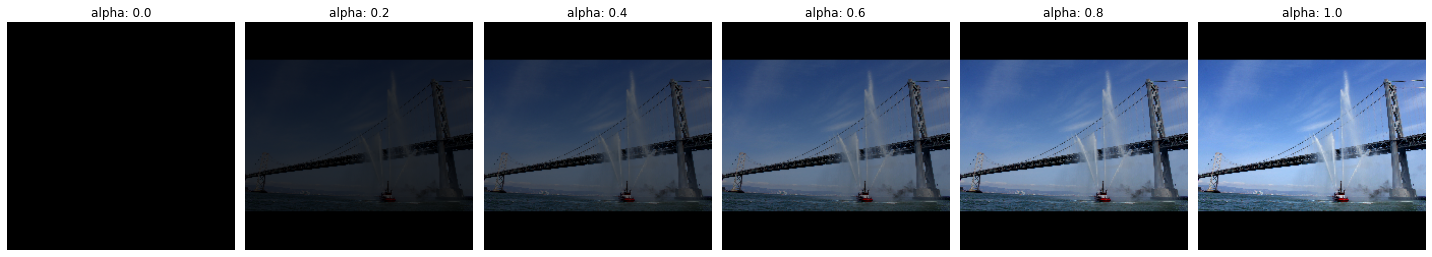

In [60]:
fig = plt.figure(figsize=(20, 20))
i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()

In [62]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [63]:
path_gradients = compute_gradients(images=interpolated_images, target_class_idx=555)

In [64]:
print(path_gradients.shape)

(51, 224, 224, 3)


(0.0, 1.0)

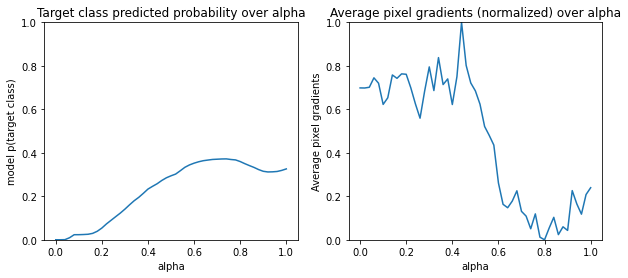

In [66]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
average_grads_norm = (average_grads - tf.math.reduce_min(average_grads)) / (tf.math.reduce_max(average_grads) - tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1])

In [67]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [68]:
ig = integral_approximation(gradients=path_gradients)

In [69]:
print(ig.shape)

(224, 224, 3)


In [73]:
@tf.function
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps + 1)
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]
        interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)
        gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)
    total_gradients = gradient_batches.stack()
    avg_gradients = integral_approximation(gradients=total_gradients)
    integral_gradients = (image - baseline) * avg_gradients
    return integral_gradients

In [74]:
ig_attributions = integrated_gradients(baseline=baseline, image=img_name_tensors['Fireboat'], target_class_idx=555,
                                      m_steps=240)

In [75]:
print(ig_attributions.shape)

(224, 224, 3)


In [85]:
def plot_img_attributions(baseline, image, target_class_idx, m_steps=50, cmap=None, overlay_alpha=0.4):
    attributions = integrated_gradients(baseline=baseline, image=image, target_class_idx=target_class_idx, 
                                        m_steps=m_steps)
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))
    axs[0, 0].set_title("Baseline image")
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')
    
    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')
    
    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')
    
    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')
    plt.tight_layout()
    return fig

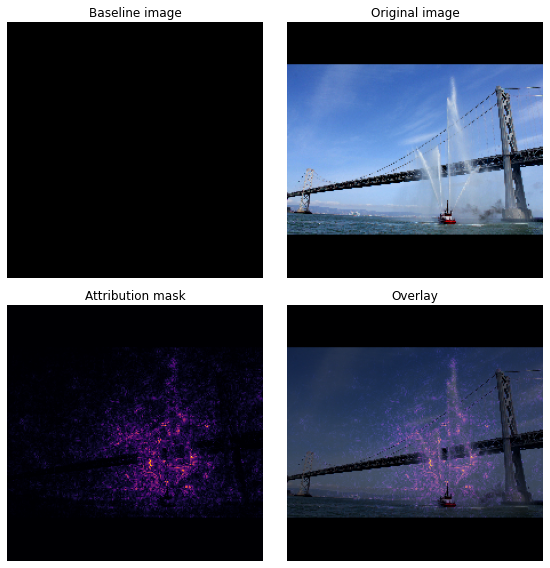

In [86]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'], baseline=baseline, target_class_idx=555, m_steps=240, 
                          cmap=plt.cm.inferno, overlay_alpha=0.4)

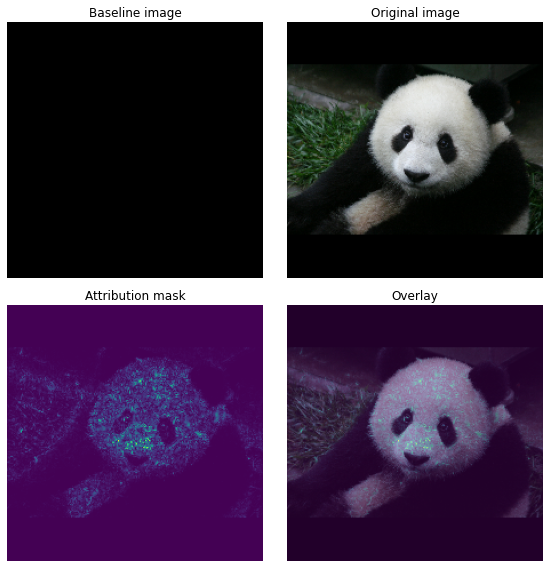

In [82]:
_ = plot_img_attributions(image=img_name_tensors['Giant Pandas'], baseline=baseline, target_class_idx=389, 
                         m_steps=55, cmap=plt.cm.viridis, overlay_alpha=0.5)

# TFP Probabilities Layers: Regression

In [5]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.7)
%matplotlib inline
tfd = tfp.distributions

In [6]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

In [7]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [8]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]
def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g ** 2)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst
y, x, x_tst = load_dataset()

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.1375906
5.1317234


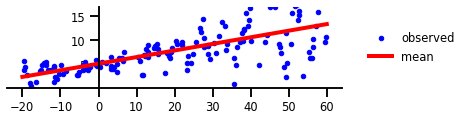

In [13]:
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())
plt.figure(figsize=[6, 1.5])
plt.plot(x, y, "b.", label="observed")
plt.plot(x_tst, yhat.mean(), 'r', label="mean", linewidth=4)
plt.ylim(-0., 17)
plt.yticks(np.linspace(0, 15, 4)[1:])
plt.xticks(np.linspace(*x_range, num=9))

ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc="center left", fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.savefig('/tmp/fig1.png', bbox_inches="tight", dpi=300)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + 
                                                       tf.math.softplus(0.05 * t[..., 1:])))
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]
yaht = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[0.12834734 0.96329653]
[5.18764   6.8989444]


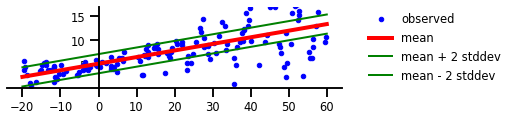

In [16]:
plt.figure(figsize=[6, 1.5])
plt.plot(x, y, "b.", label="observed")
m = yhat.mean()
s = yhat.stddev()
plt.plot(x_tst, m, "r", label="mean", linewidth=4)
plt.plot(x_tst, m + 2 * s, 'g', label="mean + 2 stddev", linewidth=2)
plt.plot(x_tst, m - 2 * s, 'g', label="mean - 2 stddev", linewidth=2)
plt.ylim(-0., 17)
plt.yticks(np.linspace(0, 15, 4)[1:])
plt.xticks(np.linspace(*x_range, num=9))

ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc="center left", fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.savefig('/tmp/fig2.png', bbox_inches="tight", dpi=300)

In [21]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t[..., :n], scale=1e-5 + 
                                                                           tf.nn.softplus(c + t[..., n:])), 
                                                                reinterpreted_batch_ndims=1))
    ])

In [22]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1), 
                                                                reinterpreted_batch_ndims=1))
    ])

In [23]:
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.13907453  5.1453633  -4.0382175  -2.3715582 ]
[0.12561221 5.1146836 ]


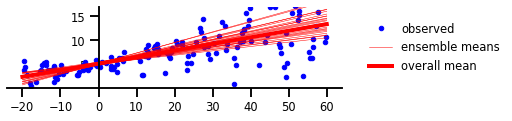

In [24]:
plt.figure(figsize=[6, 1.5])
plt.clf()
plt.plot(x, y, 'b.', label="observed")
yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 25:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)
plt.ylim(-0., 17)
plt.yticks(np.linspace(0, 15, 4)[1:])
plt.xticks(np.linspace(*x_range, num=9))

ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc="center left", fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.savefig('/tmp/fig3.png', bbox_inches="tight", dpi=300)

In [25]:
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + 
                                                       tf.math.softplus(0.01 * t[..., 1:])))
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.13684413  2.903481    5.1506      4.287091   -3.567543   -0.93300045
 -2.3521676   0.12207619]
[0.12159619 2.9427996  5.209048   4.1391625 ]


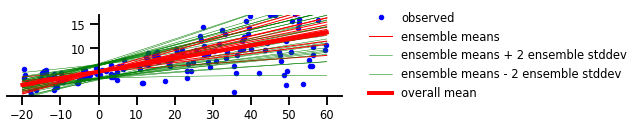

In [29]:
plt.figure(figsize=[6, 1.5])
plt.plot(x, y, 'b.', label='observed')
yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 15:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
        plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stddev' if i == 0 else None)
        plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stddev' if i == 0 else None)
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)
plt.ylim(-0, 17)
plt.yticks(np.linspace(0, 15, 4)[1:])
plt.xticks(np.linspace(*x_range, num=9))

ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc="center left", fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.savefig('/tmp/fig4.png', bbox_inches="tight", dpi=300)

In [32]:
class RBFKernelFn(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype=kwargs.get('dtype', None)
        self._amplitude = self.add_variable(initializer=tf.constant_initializer(0), dtype=dtype, name='amplitude')
        self._length_scale = self.add_variable(initializer=tf.constant_initializer(0), dtype=dtype, name='length_scale')
    def call(self, x):
        return x
    @property
    def kernel(self):
        return tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=tf.nn.softplus(0.1 * self._amplitude), 
                                                         length_scale=tf.nn.softplus(5. * self._length_scale))

In [33]:
tf.keras.backend.set_floatx('float64')
num_inducing_points = 40
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1]),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(num_inducing_points=num_inducing_points, kernel_provider=RBFKernelFn(),
                                         event_shape=[1], inducing_index_points_initializer=
                                          tf.constant_initializer(np.linspace(*x_range, num=num_inducing_points, 
                                                                              dtype=x.dtype)[..., np.newaxis]), 
                                         unconstrained_observation_noise_variance_initializer=
                                          (tf.constant_initializer(np.array(0.54).astype(x.dtype))))
])
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x, y, batch_size=batch_size, epochs=1000, verbose=False)
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


<ipython-input-32-a40adaa01ce0>:5: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._amplitude = self.add_variable(initializer=tf.constant_initializer(0), dtype=dtype, name='amplitude')
<ipython-input-32-a40adaa01ce0>:6: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._length_scale = self.add_variable(initializer=tf.constant_initializer(0), dtype=dtype, name='length_scale')
C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_probability\python\distributions\gaussian_process.py:375: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  warnings.warn(


Instructions for updating:
the `jitter` property of `tfd.GaussianProcess` is deprecated; use the `marginal_fn` property instead.


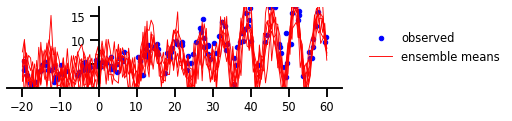

In [36]:
y, x, _ = load_dataset()
plt.figure(figsize=[6, 1.5])
plt.plot(x, y, 'b.', label='observed')
num_samples = 7
for i in range(num_samples):
    sample_ = yhat.sample().numpy()
    plt.plot(x_tst, sample_[..., 0].T, 'r', linewidth=0.9, label='ensemble means' if i == 0 else None)
plt.ylim(-0., 17)
plt.yticks(np.linspace(0, 15, 4)[1:])
plt.xticks(np.linspace(*x_range, num=9))
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc="center left", fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.savefig('/tmp/fig3.png', bbox_inches="tight", dpi=300)

# Tensorflow probability

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
def print_subclasses_from_module(module, base_class, maxwidth=80):
    import functools, inspect, sys
    subclass = [name for name, obj in inspect.getmembers(module) 
                if inspect.isclass(obj) and issubclass(obj, base_class)]
    def red(acc, x):
        if not acc or len(acc[-1]) + len(x) + 2 > maxwidth:
            acc.append(x)
        else:
            acc[-1] += ", " + x
        return acc
    print("\n".join(functools.reduce(red, subclass, [])))

In [3]:
mats = tf.random.uniform(shape=[1000, 10, 10])
vecs = tf.random.uniform(shape=[1000, 10, 1])
def for_loop_solve():
    return np.array([tf.linalg.solve(mats[i, ...], vecs[i, ...]) for i in range(1000)])

def vectorized_solve():
    return tf.linalg.solve(mats, vecs)

%timeit for_loop_solve()
%timeit vectorized_solve()

282 ms ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
619 µs ± 41.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
a = tf.constant(np.pi)
b = tf.constant(np.e)
with tf.GradientTape() as tape:
    tape.watch([a, b])
    c = .5 * (a**2 + b**2)
grads = tape.gradient(c, [a, b])
print(grads[0])
print(grads[1])

tf.Tensor(3.1415927, shape=(), dtype=float32)
tf.Tensor(2.7182817, shape=(), dtype=float32)


In [5]:
print_subclasses_from_module(tfp.distributions, tfp.distributions.Distribution)

Autoregressive, BatchBroadcast, BatchConcat, BatchReshape, Bates, Bernoulli
Beta, BetaBinomial, BetaQuotient, Binomial, Blockwise, Categorical, Cauchy, Chi
Chi2, CholeskyLKJ, ContinuousBernoulli, DeterminantalPointProcess, Deterministic
Dirichlet, DirichletMultinomial, Distribution, DoublesidedMaxwell, Empirical
ExpGamma, ExpInverseGamma, ExpRelaxedOneHotCategorical, Exponential
ExponentiallyModifiedGaussian, FiniteDiscrete, Gamma, GammaGamma
GaussianProcess, GaussianProcessRegressionModel, GeneralizedExtremeValue
GeneralizedNormal, GeneralizedPareto, Geometric, Gumbel, HalfCauchy, HalfNormal
HalfStudentT, HiddenMarkovModel, Horseshoe, Independent, InverseGamma
InverseGaussian, JohnsonSU, JointDistribution, JointDistributionCoroutine
JointDistributionCoroutineAutoBatched, JointDistributionNamed
JointDistributionNamedAutoBatched, JointDistributionSequential
JointDistributionSequentialAutoBatched, Kumaraswamy, LKJ, LambertWDistribution
LambertWNormal, Laplace, LinearGaussianStateSpaceMod

In [6]:
normal = tfd.Normal(loc=0., scale=1.)
print(normal)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


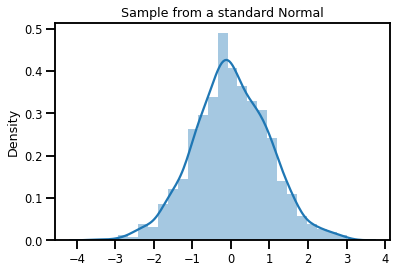

In [7]:
samples = normal.sample(1000)
sns.distplot(samples)
plt.title("Sample from a standard Normal")
plt.show()

In [8]:
normal.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [9]:
normal.log_prob([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.4189385, -0.9189385, -1.4189385], dtype=float32)>

In [10]:
normals = tfd.Normal([-2.5, 0., 2.5], 1.)
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (3,)
Event shape: ()


In [11]:
samples = normals.sample(1000)
print("Shape of samples:", samples.shape)

Shape of samples: (1000, 3)


In [12]:
print("Shape of samples:", normals.sample([10, 10, 10]).shape)

Shape of samples: (10, 10, 10, 3)


In [13]:
print(normals.log_prob(0.))

tf.Tensor([-4.0439386 -0.9189385 -4.0439386], shape=(3,), dtype=float32)


In [14]:
xs = np.linspace(-6, 6, 200)
try:
    normals.log_prob(xs)
except Exception as e:
    print("TFP error:", e.message)

TFP error: Incompatible shapes: [200] vs. [3] [Op:SquaredDifference]


In [15]:
try:
    np.zeros(200) + np.zeros(3)
except Exception as e:
    print("Numpy error:", e)

Numpy error: operands could not be broadcast together with shapes (200,) (3,) 


In [16]:
a = np.zeros([200, 1]) + np.zeros(3)
print("Broadcast shape:", a.shape)

Broadcast shape: (200, 3)


In [17]:
xs = np.linspace(-6, 6, 200)[..., np.newaxis]
lps = normals.log_prob(xs)
print("Broadcast log_prob shape:", lps.shape)

Broadcast log_prob shape: (200, 3)


C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


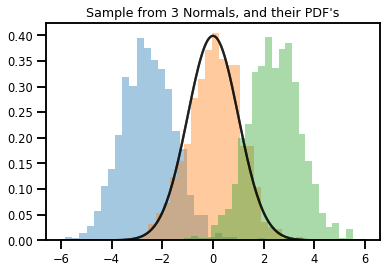

In [18]:
for i in range(3):
    sns.distplot(samples[:, i], kde=False, norm_hist=True)
plt.plot(np.tile(xs, 3), normal.prob(xs), c='k', alpha=.5)
plt.title("Sample from 3 Normals, and their PDF's")
plt.show()

In [19]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


In [20]:
samples = mvn.sample(1000)
print("Sample shape:", samples.shape)

Sample shape: (1000, 2)


# Playing CartPole with Actor-Critic Method

In [1]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

env = gym.make("CartPole-v0")
seed=42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
eps = np.finfo(np.float32).eps.item()

In [2]:
class ActorCritic(tf.keras.Model):
    def __init__(self, num_actions: int, num_hidden_units: int):
        super().__init__()
        self.common = layers.Dense(num_hidden_units, activation="relu")
        self.actor = layers.Dense(num_actions)
        self.critic = layers.Dense(1)
    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        x = self.common(inputs)
        return self.actor(x), self.critic(x)

In [3]:
num_actions = env.action_space.n
num_hidden_units = 128
model = ActorCritic(num_actions, num_hidden_units)

In [6]:
def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    state, reward, done, _ = env.step(action)
    return (state.astype(np.float32), np.array(reward, np.int32), np.array(done, np.int32))

def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
    return tf.numpy_function(env_step, [action], [tf.float32, tf.int32, tf.int32])

In [24]:
def run_episode(initial_state: tf.Tensor, model: tf.keras.Model, max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, 
                                                                                          tf.Tensor]:
    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
    initial_state_shape = initial_state.shape
    state = initial_state
    for t in tf.range(max_steps):
        state = tf.expand_dims(state, 0)
        action_logits_t, value = model(state)
        action = tf.random.categorical(action_logits_t, 1)[0, 0]
        action_probs_t = tf.nn.softmax(action_logits_t)
        values = values.write(t, tf.squeeze(value))
        action_probs = action_probs.write(t, action_probs_t[0, action])
        state, reward, done = tf_env_step(action)
        state.set_shape(initial_state_shape)
        rewards = rewards.write(t, reward)
        if tf.cast(done, tf.bool):
            break
    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()
    return action_probs, values, rewards

In [25]:
def get_expected_return(rewards: tf.Tensor, gamma: float, standardize: bool=True)-> tf.Tensor:
    n = tf.shape(rewards)[0]
    returns = tf.TensorArray(dtype=tf.float32, size=n)
    rewards = tf.cast(rewards[::-1], dtype=tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    returns = returns.stack()[::-1]
    if standardize:
        returns = ((returns - tf.math.reduce_mean(returns)) / (tf.math.reduce_std(returns) + eps))
    return returns

In [26]:
huber_loss = tf.keras.losses.Huber(reduction = tf.keras.losses.Reduction.SUM)
def compute_loss(action_probs: tf.Tensor, values: tf.Tensor, returns: tf.Tensor) -> tf.Tensor:
    advantage = returns - values
    action_log_probs = tf.math.log(action_probs)
    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)
    critic_loss = huber_loss(values, returns)
    return actor_loss + critic_loss

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
@tf.function
def train_step(initial_state: tf.Tensor, model: tf.keras.Model, optimizer: tf.keras.optimizers.Optimizer, gamma: float,
              max_steps_per_episode: int)-> tf.Tensor:
    with tf.GradientTape() as tape:
        action_probs, values, rewards = run_episode(initial_state, model, max_steps_per_episode)
        returns = get_expected_return(rewards, gamma)
        action_probs, values, returns = [tf.expand_dims(x, 1) for x in [action_probs, values, returns]]
        loss = compute_loss(action_probs, values, returns)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    episode_reward = tf.math.reduce_sum(rewards)
    return episode_reward

In [33]:
%%time
min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000
reward_threshold = 195
running_reward = 0
gamma = 0.99
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)
with tqdm.trange(max_episodes) as t:
    for i in t:
        initial_state = tf.constant(env.reset(), dtype=tf.float32)
        episode_reward = int(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))
        episodes_reward.append(episode_reward)
        running_reward = statistics.mean(episodes_reward)
        t.set_description(f'Episode {i}')
        t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)
        if i % 10 == 0:
            pass
        if running_reward > reward_threshold and i >= min_episodes_criterion:
            break
print(f"\n Solved at episode {i}: average reward: {running_reward:.2f}!")

Episode 777:   8%|▊         | 777/10000 [00:44<08:46, 17.50it/s, episode_reward=200, running_reward=196] 


 Solved at episode 777: average reward: 195.61!
Wall time: 44.4 s


In [37]:
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display

In [40]:
display = Display(visible=0, size=(400, 300))
display.start()
def render_episode(env: gymEnv, model: tf.keras.Model, max_steps: int):
    screen = env.rander(mode='rgb_array')
    im = Image.fromarray(screen)
    images = [im]
    state = tf.constant(env.reset(), dtype=tf.float32)
    for i in range(1, max_steps + 1):
        state = tf.expand_dims(state, 0)
        action_probs, _ = model(state)
        action = np.argmax(np.sqeeze(action_probs))
        state, _, done, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)
        if i % 10 == 0:
            screen = env.render(mode='rgb_array')
            images.append(Image.fromarray(screen))
        if done:
            break
    return images

images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

EasyProcessError: start error <EasyProcess cmd_param=['Xvfb', '-help'] cmd=['Xvfb', '-help'] oserror=[WinError 2] The system cannot find the file specified return_code=None stdout="None" stderr="None" timeout_happened=False>

# Premade estimators

In [2]:
import tensorflow as tf
import pandas as pd

In [3]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

In [4]:
train_path = tf.keras.utils.get_file("iris_training.csv", 
                                     "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file("iris_test.csv", 
                                   "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")
train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

In [5]:
train.head()

SepalLength  SepalWidth  PetalLength  PetalWidth  Species
0          6.4         2.8          5.6         2.2        2
1          5.0         2.3          3.3         1.0        1
2          4.9         2.5          4.5         1.7        2
3          4.9         3.1          1.5         0.1        0
4          5.7         3.8          1.7         0.3        0

In [6]:
train_y = train.pop('Species')
test_y = test.pop("Species")
train.head()

SepalLength  SepalWidth  PetalLength  PetalWidth
0          6.4         2.8          5.6         2.2
1          5.0         2.3          3.3         1.0
2          4.9         2.5          4.5         1.7
3          4.9         3.1          1.5         0.1
4          5.7         3.8          1.7         0.3

In [7]:
def input_evaluation_set():
    features = {"SepalLength": np.array([6.4, 5.0]),
               "SepalWidth": np.array([2.8, 2.3]),
               'PetalLength': np.array([5.6, 3.3]),
               'PetalWidth': np.array([2.2, 1.0])}
    labels = np.array([2, 1])
    return features, labels

In [8]:
def input_fn(features, labels, training=True, batch_size=256):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [9]:
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

In [10]:
my_feature_columns

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [11]:
classifier = tf.estimator.DNNClassifier(feature_columns = my_feature_columns, hidden_units=[30, 10], n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\jatin\\AppData\\Local\\Temp\\tmp90oxz6pv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
classifier.train(input_fn=lambda: input_fn(train, train_y, training=True), steps=5000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\jatin\AppData\Local\Temp\tmp90oxz6pv\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.5799329, step = 0
INFO:tensorflow:global_step/sec: 171.41
INFO:tensorflow:loss = 1.0899602, step = 100 (0.590 sec)
INFO:tensorflow:global_step/sec: 232.691
INFO:tensorflow:loss = 1.0168006, step = 200 (0.424 sec)
INF

In [13]:
eval_result = classifier.evaluate(input_fn=lambda: input_fn(test, test_y, training=False))
print("\nTest set accuracy: {accuracy:0.3f}\n".format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-02-08T00:58:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\jatin\AppData\Local\Temp\tmp90oxz6pv\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 2.69670s
INFO:tensorflow:Finished evaluation at 2022-02-08-00:58:53
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.76666665, average_loss = 0.6045934, global_step = 5000, loss = 0.6045934
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: C:\Users\jatin\AppData\Local\Temp\tmp90oxz6pv\model.ckpt-5000

Test set accuracy: 0.767



In [20]:
expected = ["Setosa", "Versicolor", "Virginica"]
predicted_x = {
    'SepalLength':[5.1, 5.9, 6.9],
    'SepalWidth':[3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1]
}
def input_fn(features, batch_size=256):
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)
predictions = classifier.predict(input_fn=lambda: input_fn(predicted_x))

In [21]:
for pred_dict, expec in zip(predictions, expected):
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]
    print('Prediction is "{}" ({:.1f}%), expected "{}"'.format(SPECIES[class_id], 100 * probability, expec))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\jatin\AppData\Local\Temp\tmp90oxz6pv\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Setosa" (70.1%), expected "Setosa"
Prediction is "Virginica" (44.5%), expected "Versicolor"
Prediction is "Virginica" (56.2%), expected "Virginica"


# Build a linear model with Estimators

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [2]:
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [3]:
dftrain = pd.read_csv('D:/datasets_CSV/train.csv')
dfeval = pd.read_csv('D:/datasets_CSV/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [4]:
dftrain.head()

sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y

In [5]:
dftrain.describe()

age  n_siblings_spouses       parch        fare
count  627.000000          627.000000  627.000000  627.000000
mean    29.631308            0.545455    0.379585   34.385399
std     12.511818            1.151090    0.792999   54.597730
min      0.750000            0.000000    0.000000    0.000000
25%     23.000000            0.000000    0.000000    7.895800
50%     28.000000            0.000000    0.000000   15.045800
75%     35.000000            1.000000    0.000000   31.387500
max     80.000000            8.000000    5.000000  512.329200

In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

<AxesSubplot:>

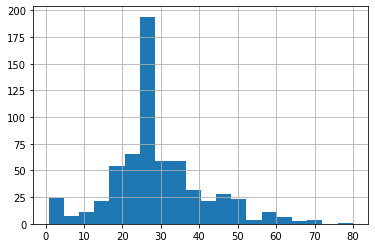

In [7]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

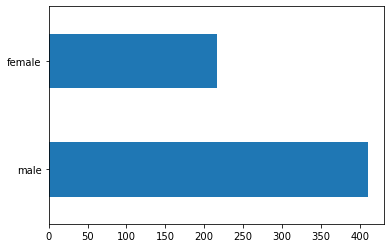

In [8]:
dftrain.sex.value_counts().plot(kind="barh")

<AxesSubplot:>

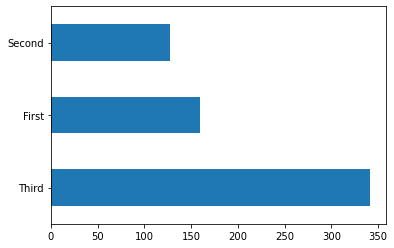

In [9]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

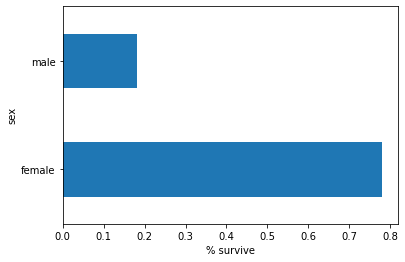

In [10]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [11]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [12]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [13]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print("Some feature keys:", list(feature_batch.keys()))
    print()
    print("A batch of class:", feature_batch['class'].numpy())
    print()
    print('A batch of Label:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'First' b'Third' b'First' b'First' b'Third' b'Third' b'Second' b'Third'
 b'First' b'Second']

A batch of Label: [1 0 0 0 0 0 1 0 1 1]


In [14]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[27.],
       [20.],
       [24.],
       [50.],
       [28.],
       [20.],
       [50.],
       [22.],
       [25.],
       [22.]], dtype=float32)

In [15]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [16]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(result)

{'accuracy': 0.7689394, 'accuracy_baseline': 0.625, 'auc': 0.8322927, 'auc_precision_recall': 0.77818733, 'average_loss': 0.50229204, 'label/mean': 0.375, 'loss': 0.49319473, 'precision': 0.75, 'prediction/mean': 0.293766, 'recall': 0.57575756, 'global_step': 200}


In [17]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [18]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns + derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(result)

{'accuracy': 0.7462121, 'accuracy_baseline': 0.625, 'auc': 0.84401596, 'auc_precision_recall': 0.7876678, 'average_loss': 0.47096622, 'label/mean': 0.375, 'loss': 0.46338505, 'precision': 0.6509434, 'prediction/mean': 0.4129865, 'recall': 0.6969697, 'global_step': 200}


INFO:tensorflow:Calling model_fn.


C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\jatin\AppData\Local\Temp\tmpaid1fvqc\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

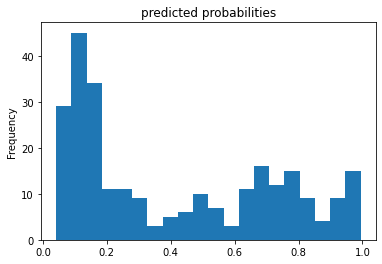

In [20]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred["probabilities"][1] for pred in pred_dicts])
probs.plot(kind="hist", bins=20, title="predicted probabilities")

(0.0, 1.05)

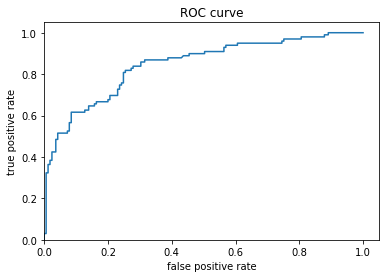

In [21]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.xlabel("false positive rate")
plt.ylabel('true positive rate')
plt.title("ROC curve")
plt.xlim(0,)
plt.ylim(0,)

# Create estimator from a keras model

In [23]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=(4,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])

In [25]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [27]:
def input_fn():
    split = tfds.Split.TRAIN
    dataset = tfds.load("iris", split=split, as_supervised=True)
    dataset = dataset.map(lambda features, labels: ({"dense_input":features}, labels))
    dataset = dataset.batch(32).repeat()
    return dataset

In [29]:
for features_batch, labels_batch in input_fn().take(1):
    print(features_batch)
    print(labels_batch)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling iris-train.tfrecord...:   0%|          | 0/150 [00:00<?, ? examples/s]

Dataset iris downloaded and prepared to C:\Users\jatin\tensorflow_datasets\iris\2.0.0. Subsequent calls will reuse this data.
{'dense_input': <tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[5.1, 3.4, 1.5, 0.2],
       [7.7, 3. , 6.1, 2.3],
       [5.7, 2.8, 4.5, 1.3],
       [6.8, 3.2, 5.9, 2.3],
       [5.2, 3.4, 1.4, 0.2],
       [5.6, 2.9, 3.6, 1.3],
       [5.5, 2.6, 4.4, 1.2],
       [5.5, 2.4, 3.7, 1. ],
       [4.6, 3.4, 1.4, 0.3],
       [7.7, 2.8, 6.7, 2. ],
       [7. , 3.2, 4.7, 1.4],
       [4.6, 3.2, 1.4, 0.2],
       [6.5, 3. , 5.2, 2. ],
       [5.5, 4.2, 1.4, 0.2],
       [5.4, 3.9, 1.3, 0.4],
       [5. , 3.5, 1.3, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [4.8, 3. , 1.4, 0.1],
       [6.5, 3. , 5.8, 2.2],
       [7.6, 3. , 6.6, 2.1],
       [6.7, 3.3, 5.7, 2.1],
       [7.9, 3.8, 6.4, 2. ],
       [6.7, 3. , 5.2, 2.3],
       [5.8, 4. , 1.2, 0.2],
       [6.3, 2.5, 5. , 1.9],
       [5. , 3. , 1.6, 0.2],
       [6.9, 3.1, 5.1, 2.3],
       [6.1, 3. , 4.6, 1.4

In [30]:
import tempfile
model_dir = tempfile.mkdtemp()
keras_estimator = tf.keras.estimator.model_to_estimator(keras_model=model, model_dir=model_dir)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using the Keras model provided.


INFO:tensorflow:Using the Keras model provided.
C:\Users\jatin\anaconda3\lib\site-packages\keras\backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\jatin\\AppData\\Local\\Temp\\tmpe65fnkxj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\jatin\\AppData\\Local\\Temp\\tmpe65fnkxj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [32]:
keras_estimator.train(input_fn=input_fn, steps=500)
eval_result = keras_estimator.evaluate(input_fn=input_fn, steps=10)
print("Eval result: {}".format(eval_result))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\jatin\AppData\Local\Temp\tmpe65fnkxj\model.ckpt-500


INFO:tensorflow:Restoring parameters from C:\Users\jatin\AppData\Local\Temp\tmpe65fnkxj\model.ckpt-500


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500...


INFO:tensorflow:Saving checkpoints for 500 into C:\Users\jatin\AppData\Local\Temp\tmpe65fnkxj\model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into C:\Users\jatin\AppData\Local\Temp\tmpe65fnkxj\model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500...


INFO:tensorflow:loss = 0.42426887, step = 500


INFO:tensorflow:loss = 0.42426887, step = 500


INFO:tensorflow:global_step/sec: 386.069


INFO:tensorflow:global_step/sec: 386.069


INFO:tensorflow:loss = 0.29397997, step = 600 (0.266 sec)


INFO:tensorflow:loss = 0.29397997, step = 600 (0.266 sec)


INFO:tensorflow:global_step/sec: 584.455


INFO:tensorflow:global_step/sec: 584.455


INFO:tensorflow:loss = 0.25666213, step = 700 (0.163 sec)


INFO:tensorflow:loss = 0.25666213, step = 700 (0.163 sec)


INFO:tensorflow:global_step/sec: 589.052


INFO:tensorflow:global_step/sec: 589.052


INFO:tensorflow:loss = 0.16292717, step = 800 (0.188 sec)


INFO:tensorflow:loss = 0.16292717, step = 800 (0.188 sec)


INFO:tensorflow:global_step/sec: 495.205


INFO:tensorflow:global_step/sec: 495.205


INFO:tensorflow:loss = 0.2133119, step = 900 (0.191 sec)


INFO:tensorflow:loss = 0.2133119, step = 900 (0.191 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...


INFO:tensorflow:Saving checkpoints for 1000 into C:\Users\jatin\AppData\Local\Temp\tmpe65fnkxj\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into C:\Users\jatin\AppData\Local\Temp\tmpe65fnkxj\model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...


INFO:tensorflow:Loss for final step: 0.32645485.


INFO:tensorflow:Loss for final step: 0.32645485.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-02-08T19:15:05


INFO:tensorflow:Starting evaluation at 2022-02-08T19:15:05


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\jatin\AppData\Local\Temp\tmpe65fnkxj\model.ckpt-1000


INFO:tensorflow:Restoring parameters from C:\Users\jatin\AppData\Local\Temp\tmpe65fnkxj\model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


INFO:tensorflow:Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


INFO:tensorflow:Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


INFO:tensorflow:Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


INFO:tensorflow:Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


INFO:tensorflow:Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


INFO:tensorflow:Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


INFO:tensorflow:Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


INFO:tensorflow:Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


INFO:tensorflow:Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


INFO:tensorflow:Evaluation [10/10]


INFO:tensorflow:Inference Time : 0.43593s


INFO:tensorflow:Inference Time : 0.43593s


INFO:tensorflow:Finished evaluation at 2022-02-08-19:15:05


INFO:tensorflow:Finished evaluation at 2022-02-08-19:15:05


INFO:tensorflow:Saving dict for global step 1000: global_step = 1000, loss = 0.16319637


INFO:tensorflow:Saving dict for global step 1000: global_step = 1000, loss = 0.16319637


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\jatin\AppData\Local\Temp\tmpe65fnkxj\model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\jatin\AppData\Local\Temp\tmpe65fnkxj\model.ckpt-1000


Eval result: {'loss': 0.16319637, 'global_step': 1000}


# Multi-worker training with Estimator

In [33]:
import tensorflow_datasets as tfds
import tensorflow as tf
import os, json

In [34]:
tf.compat.v1.disable_eager_execution()

In [35]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
def input_fn(mode, input_context=None):
    datasets, info = tfds.load(name="mnist", with_info=True, as_supervised=True)
    mnist_dataset = (datasets["train"] if mode == tf.estimator.ModeKeys.TRAIN else datasets["test"])
    def scale(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label
    if input_context:
        mnist_dataset = mnist_dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)
    return mnist_dataset.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [36]:
os.environ['TF_CONFIG'] = json.dumps({
    "cluster": {
        "worker": ["localhost:12345", "localhost:23456"]
    },
    "task": {"type":"worker", "index":0}
})

In [41]:
LEARNING_RATE = 1e-4
def model_fn(features, labels, mode):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(10)
    ])
    logits = model(features, training=False)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {'logits':logits}
        return tf.estimator.EstimatorSpec(labels=labels, predictions=predictions)
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=
                                                         tf.keras.losses.Reduction.NONE)(labels, logits)
    loss = tf.reduce_sum(loss) * (1. / BATCH_SIZE)
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss)
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=optimizer.minimize(loss, tf.compat.v1.train.get_or_create_global_step()))

In [42]:
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

INFO:tensorflow:Check health not enabled.


INFO:tensorflow:Check health not enabled.


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345', 'localhost:23456']}, task_type = 'worker', task_id = 0, num_workers = 2, local_devices = ('/job:worker/task:0/device:CPU:0',), communication = CommunicationImplementation.AUTO


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345', 'localhost:23456']}, task_type = 'worker', task_id = 0, num_workers = 2, local_devices = ('/job:worker/task:0/device:CPU:0',), communication = CommunicationImplementation.AUTO


In [ ]:
config = tf.estimator.RunConfig(train_distribute=strategy)
classifier = tf.estimator.Estimator(model_fn=model_fn, model_dir="/tmp/multiworker", config=config)
tf.estimator.train_and_evaluate(classifier, train_spec=tf.estimator.TrainSpec(input_fn=input_fn), 
                                eval_spec=tf.estimator.EvalSpec(input_fn=input_fn))

INFO:tensorflow:TF_CONFIG environment variable: {'cluster': {'worker': ['localhost:12345', 'localhost:23456']}, 'task': {'type': 'worker', 'index': 0}}


INFO:tensorflow:TF_CONFIG environment variable: {'cluster': {'worker': ['localhost:12345', 'localhost:23456']}, 'task': {'type': 'worker', 'index': 0}}


INFO:tensorflow:Initializing RunConfig with distribution strategies.


INFO:tensorflow:Initializing RunConfig with distribution strategies.


INFO:tensorflow:RunConfig initialized for Distribute Coordinator with INDEPENDENT_WORKER mode


INFO:tensorflow:RunConfig initialized for Distribute Coordinator with INDEPENDENT_WORKER mode


INFO:tensorflow:Using config: {'_model_dir': '/tmp/multiworker', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.collective_all_reduce_strategy._CollectiveAllReduceStrategyExperimental object at 0x0000026A39430520>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['localhost:12345', 'localhost:23456']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': 

INFO:tensorflow:Using config: {'_model_dir': '/tmp/multiworker', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.collective_all_reduce_strategy._CollectiveAllReduceStrategyExperimental object at 0x0000026A39430520>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['localhost:12345', 'localhost:23456']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': 

INFO:tensorflow:Running `train_and_evaluate` with Distribute Coordinator.


INFO:tensorflow:Running `train_and_evaluate` with Distribute Coordinator.


INFO:tensorflow:Running Distribute Coordinator with mode = 'independent_worker', cluster_spec = {'worker': ['localhost:12345', 'localhost:23456']}, task_type = 'worker', task_id = 0, environment = None, rpc_layer = 'grpc'


INFO:tensorflow:Running Distribute Coordinator with mode = 'independent_worker', cluster_spec = {'worker': ['localhost:12345', 'localhost:23456']}, task_type = 'worker', task_id = 0, environment = None, rpc_layer = 'grpc'


INFO:tensorflow:Check health not enabled.


INFO:tensorflow:Check health not enabled.


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345', 'localhost:23456']}, task_type = 'worker', task_id = 0, num_workers = 2, local_devices = ('/job:worker/task:0/device:CPU:0',), communication = CommunicationImplementation.AUTO


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345', 'localhost:23456']}, task_type = 'worker', task_id = 0, num_workers = 2, local_devices = ('/job:worker/task:0/device:CPU:0',), communication = CommunicationImplementation.AUTO


INFO:tensorflow:Check health not enabled.


INFO:tensorflow:Check health not enabled.


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345', 'localhost:23456']}, task_type = 'worker', task_id = 0, num_workers = 2, local_devices = ('/job:worker/task:0/device:CPU:0',), communication = CommunicationImplementation.AUTO


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345', 'localhost:23456']}, task_type = 'worker', task_id = 0, num_workers = 2, local_devices = ('/job:worker/task:0/device:CPU:0',), communication = CommunicationImplementation.AUTO


INFO:tensorflow:Updated config: {'_model_dir': '/tmp/multiworker', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.collective_all_reduce_strategy._CollectiveAllReduceStrategyExperimental object at 0x0000026A37F5D280>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['localhost:12345', 'localhost:23456']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://localhost:12345', '_evaluation_ma

INFO:tensorflow:Updated config: {'_model_dir': '/tmp/multiworker', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.collective_all_reduce_strategy._CollectiveAllReduceStrategyExperimental object at 0x0000026A37F5D280>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['localhost:12345', 'localhost:23456']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://localhost:12345', '_evaluation_ma

INFO:tensorflow:The `input_fn` accepts an `input_context` which will be given by DistributionStrategy


INFO:tensorflow:The `input_fn` accepts an `input_context` which will be given by DistributionStrategy


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Collective all_reduce tensors: 6 all_reduces, num_devices = 1, group_size = 2, implementation = AUTO, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 6 all_reduces, num_devices = 1, group_size = 2, implementation = AUTO, num_packs = 1


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 2, implementation = AUTO, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 2, implementation = AUTO, num_packs = 1


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:all_hooks [<tensorflow_estimator.python.estimator.util.DistributedIteratorInitializerHook object at 0x0000026A39324E80>, <tensorflow.python.training.basic_session_run_hooks.NanTensorHook object at 0x0000026A3917B970>, <tensorflow.python.training.basic_session_run_hooks.LoggingTensorHook object at 0x0000026A392786A0>, <tensorflow.python.training.basic_session_run_hooks.StepCounterHook object at 0x0000026A39199730>, <tensorflow.python.training.basic_session_run_hooks.SummarySaverHook object at 0x0000026A391845B0>, <tensorflow.python.training.basic_session_run_hooks.CheckpointSaverHook object at 0x0000026A391848E0>]


INFO:tensorflow:all_hooks [<tensorflow_estimator.python.estimator.util.DistributedIteratorInitializerHook object at 0x0000026A39324E80>, <tensorflow.python.training.basic_session_run_hooks.NanTensorHook object at 0x0000026A3917B970>, <tensorflow.python.training.basic_session_run_hooks.LoggingTensorHook object at 0x0000026A392786A0>, <tensorflow.python.training.basic_session_run_hooks.StepCounterHook object at 0x0000026A39199730>, <tensorflow.python.training.basic_session_run_hooks.SummarySaverHook object at 0x0000026A391845B0>, <tensorflow.python.training.basic_session_run_hooks.CheckpointSaverHook object at 0x0000026A391848E0>]


INFO:tensorflow:Creating chief session creator with config: device_filters: "/job:worker/task:0"
allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
    scoped_allocator_optimization: ON
    scoped_allocator_opts {
      enable_op: "CollectiveReduce"
    }
  }
}
experimental {
  collective_group_leader: "/job:worker/replica:0/task:0"
}



INFO:tensorflow:Creating chief session creator with config: device_filters: "/job:worker/task:0"
allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
    scoped_allocator_optimization: ON
    scoped_allocator_opts {
      enable_op: "CollectiveReduce"
    }
  }
}
experimental {
  collective_group_leader: "/job:worker/replica:0/task:0"
}



Instructions for updating:
Use the iterator's `initializer` property instead.


Instructions for updating:
Use the iterator's `initializer` property instead.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


# Classify structured data with feature columns

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
import pathlib
dataset_url = "http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip"
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'
tf.keras.utils.get_file('petfinder_mini.zip', dataset_url, extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

1679360/1668792 [==============================] - 23s 14us/step


In [4]:
dataframe.head()

Type  Age                Breed1  Gender Color1    Color2 MaturitySize  \
0  Cat    3                 Tabby    Male  Black     White        Small   
1  Cat    1  Domestic Medium Hair    Male  Black     Brown       Medium   
2  Dog    1           Mixed Breed    Male  Brown     White       Medium   
3  Dog    4           Mixed Breed  Female  Black     Brown       Medium   
4  Dog    1           Mixed Breed    Male  Black  No Color       Medium   

  FurLength Vaccinated Sterilized   Health  Fee  \
0     Short         No         No  Healthy  100   
1    Medium   Not Sure   Not Sure  Healthy    0   
2    Medium        Yes         No  Healthy    0   
3     Short        Yes         No  Healthy  150   
4     Short         No         No  Healthy    0   

                                         Description  PhotoAmt  AdoptionSpeed  
0  Nibble is a 3+ month old ball of cuteness. He ...         1              2  
1  I just found it alone yesterday near my apartm...         2              0  
2  Their pregnant mother was dumped by her irresp...         7              3  
3  Good guard dog, very alert, active, obedience ...         8              2  
4  This handsome yet cute boy is up for adoption....         3              2

In [5]:
dataframe['target'] = np.where(dataframe['AdoptionSpeed'] == 4, 0, 1)
dataframe = dataframe.drop(columns=["AdoptionSpeed", "Description"])

In [6]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), "train examples")
print(len(val), "validation examples")
print(len(test), "test examples")

7383 train examples
1846 validation examples
2308 test examples


In [7]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [8]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [9]:
for feature_batch, label_batch in train_ds.take(1):
    print("Every feature", list(feature_batch.keys()))
    print("A batch of ages:", feature_batch["Age"])
    print("A batch of targets:", label_batch)

Every feature ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 3  7 18  3 36], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 0], shape=(5,), dtype=int32)


In [10]:
example_batch = next(iter(train_ds))[0]

In [11]:
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [12]:
photo_count = feature_column.numeric_column("PhotoAmt")
demo(photo_count)

[[ 3.]
 [ 4.]
 [ 1.]
 [11.]
 [ 8.]]


In [13]:
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 3, 5])
demo(age_buckets)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [14]:
animal_type = feature_column.categorical_column_with_vocabulary_list('Type', ["Cat", "Dog"])
animal_type_one_hot = feature_column.indicator_column(animal_type)
demo(animal_type_one_hot)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [15]:
breed1 = feature_column.categorical_column_with_vocabulary_list('Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
demo(breed1_embedding)

[[-0.12464599 -0.1818702   0.3672403  -0.07309894  0.60239774 -0.19893324
  -0.48251638 -0.05209199]
 [-0.0420877   0.26987848 -0.5516391   0.2216294  -0.02393233 -0.18356189
  -0.31138694 -0.10320028]
 [-0.12464599 -0.1818702   0.3672403  -0.07309894  0.60239774 -0.19893324
  -0.48251638 -0.05209199]
 [-0.0420877   0.26987848 -0.5516391   0.2216294  -0.02393233 -0.18356189
  -0.31138694 -0.10320028]
 [-0.34229568 -0.37473345 -0.01801418  0.04693615  0.23355384  0.34585276
  -0.23036528  0.4012368 ]]


In [16]:
breed1_hashed = feature_column.categorical_column_with_hash_bucket("Breed1", hash_bucket_size=10)
demo(feature_column.indicator_column(breed1_hashed))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [17]:
crossed_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [18]:
feature_columns = []
for header in ['PhotoAmt', "Fee", "Age"]:
   feature_columns.append(feature_column.numeric_column(header)) 

In [20]:
age = feature_column.numeric_column("Age")
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

In [21]:
indicator_column_names = ["Type", "Color1", "Color2", "Gender", "MaturitySize", 'FurLength', "Vaccinated", 
                          "Sterilized", "Health"]
for col_name in indicator_column_names:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(col_name, dataframe[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

In [22]:
breed1 = feature_column.categorical_column_with_vocabulary_list('Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
feature_columns.append(breed1_embedding)

In [23]:
age_type_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=100)
feature_columns.append(feature_column.indicator_column(age_type_feature))

In [24]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [25]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [27]:
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dropout(.1),
    layers.Dense(1)
])
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
223/231 [===========================>..] - ETA: 0s - loss: 0.6513 - accuracy: 0.6776WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Type': <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=string>, 'Age': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int64>, 'Breed1': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=string>, 'Gender': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=string>, 'Color1': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'Color2': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=string>, 'MaturitySize': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=string>, 'FurLength': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'Vaccinated': <tf.Tensor 'IteratorGetNext:12' shape=(None,) dtype=string>, 'Sterilized': <tf.Tensor 'It

In [28]:
loss, accuracy = model.evaluate(test_ds)
print("Accuacy", accuracy)

73/73 [==============================] - 0s 4ms/step - loss: 0.5233 - accuracy: 0.6824
Accuacy 0.6824089884757996
